# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
from maddpg_agent import Agent, ReplayBuffer

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Project Solution
The solution uses a Multiagent DDPG algorithm in maddpg_agent.py. 

We primarily use the DDPG algorithm with the following design decisions
* Batch normalization for both actor and crtitic which was very important in making the learning tractable
* we update the agent networks multiple times for each time step after episode 200 to speed up learning
* We use the same OU noise for exploration - additionaly we needed a dampening factor of epsilon to have more exploration in the initial episodes. We discount episilon over 4000 episodes

In [5]:
def ma_ddpg_run(n_episodes=200, max_t=5000, buffer_size=1e6, 
                batch_size=128, gamma=0.99, tau=1e-3, lr_actor=1e-3, lr_critic=1e-3, 
                weight_decay=0, update_frequency=1, eps_start=5):

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)
    action_size = brain.vector_action_space_size
    
    agents = [Agent(state_size, action_size, num_agents=1, random_seed=1, replay_buffer_len=buffer_size,
                    batch_size=batch_size, lr_actor=lr_actor, lr_critic=lr_critic, weight_decay=weight_decay,
                    update_frequency=update_frequency, gamma=gamma, tau=tau, eps_start=eps_start, eps_end_episode=4000) for i in range(num_agents)]
    

    states = env_info.vector_observations
    scores_hist_agent1 = []
    scores_hist_agent2 = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        states = np.reshape(env_info.vector_observations, (1,num_agents*state_size))
        
        for agent in agents:
            agent.reset()
        
        scores = np.zeros(num_agents)
        while True:
            actions = [agent.act(states, add_noise=True) for agent in agents]
            actions = np.reshape(actions, (1, num_agents*action_size))
            
            env_info = env.step(actions)[brain_name]
            next_states = np.reshape(env_info.vector_observations, (1,num_agents*state_size))
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += np.max(rewards)
            
            for i, agent in enumerate(agents):
                agent.step(states, actions, rewards[i], next_states, dones, i, i_episode)
            
            states = next_states
  
            if np.any(dones):
                env_info = env.reset(train_mode=True)[brain_name]
                break    

        scores_window.append(np.max(scores))  
        scores_hist_agent1.append(scores[0]) 
        scores_hist_agent2.append(scores[1])
        avg_score = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.4f} Agent Score: {:.4f}'.format(i_episode, avg_score, np.max(scores)), end="")
        
        if avg_score >= 0.5: 
            print('Environment Solved in {} epidodes: Average score: {:.4f}', avg_score)
            return agents, scores_hist_agent1, scores_hist_agent2, scores_window
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f} Agent Score: {:.4f}'.format(i_episode, np.mean(scores_window), np.max(scores)))
    return agents, scores_hist_agent1, scores_hist_agent2, scores_window

In [6]:
multi_agents, s1, s2, sw = ma_ddpg_run(n_episodes=1000, buffer_size=1e6, lr_actor=1e-3, lr_critic=1e-3, 
                                   weight_decay=0, batch_size=128, update_frequency=1, tau=1e-2)

Episode 100	Average Score: 0.0250 Agent Score: 0.0000
Episode 200	Average Score: 0.0460 Agent Score: 0.1000
Episode 300	Average Score: 0.0980 Agent Score: 0.1000
Episode 400	Average Score: 0.1890 Agent Score: 0.0000
Episode 500	Average Score: 0.1880 Agent Score: 0.1000
Episode 600	Average Score: 0.2998 Agent Score: 0.8000
Episode 700	Average Score: 0.4959 Agent Score: 0.7000
Episode 702	Average Score: 0.5009 Agent Score: 0.7000Environment Solved in {} epidodes: Average score: {:.4f} 0.5009000074863433


In [12]:
print("Environment solved in 702 episodes {}".format(np.mean(sw)))

Environment solved in 702 episodes 0.5009000074863433


### Saving the results

In [7]:
torch.save(multi_agents[0].actor_local.state_dict(), 'checkpoints/agent0_actor_local_weights.pth')
torch.save(multi_agents[0].critic_local.state_dict(), 'checkpoints/agent0_critic_local_weights.pth')
torch.save(multi_agents[0].actor_target.state_dict(), 'checkpoints/agent0_actor_target_weights.pth')
torch.save(multi_agents[0].critic_target.state_dict(), 'checkpoints/agent0_critic_target_weights.pth')
torch.save(multi_agents[1].actor_local.state_dict(), 'checkpoints/agent1_actor_local_weights.pth')
torch.save(multi_agents[1].critic_local.state_dict(), 'checkpoints/agent1_critic_local_weights.pth')
torch.save(multi_agents[1].actor_target.state_dict(), 'checkpoints/agent1_actor_target_weights.pth')
torch.save(multi_agents[1].critic_target.state_dict(), 'checkpoints/agent1_critic_target_weights.pth')

In [ ]:
env.close()

### Results

In [14]:
score_window = deque(maxlen=100)
moving_average = []
for i1,i2 in zip(s1,s2):
    score_window.append(max(i1,i2))
    moving_average.append(np.mean(score_window))

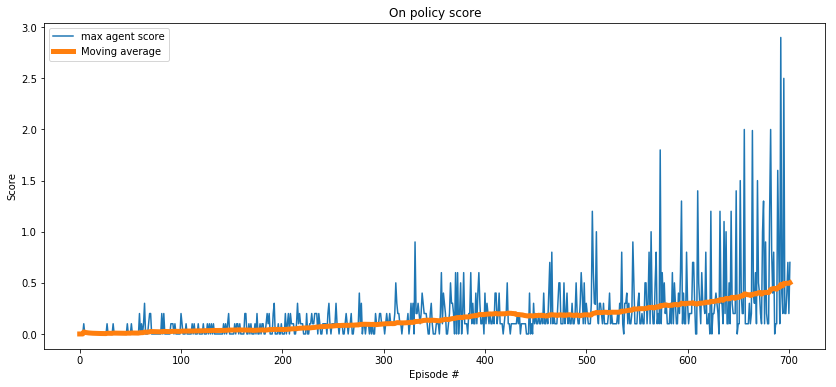

In [19]:
plt.figure(figsize=(14,6) )
plt.plot([max(i1,i2) for i1,i2 in zip(s1,s2)], label='max agent score')
plt.plot(moving_average, label='Moving average', lw=5)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("On policy score")
plt.legend()
plt.savefig('plots/MADDPG_rewards.png')

### Trained agents playing for 5 episodes

In [20]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = np.reshape(env_info.vector_observations, (1,num_agents*state_size))                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = [agent.act(states, add_noise=False) for agent in multi_agents]
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        actions = np.reshape(actions, (1, num_agents*action_size))
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = np.reshape(env_info.vector_observations, (1,num_agents*state_size))         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break